In [54]:
from qutip import *
import numpy as np
from time import process_time
import matplotlib.pyplot as plt
import psutil

from scipy import signal

from IPython.display import display, clear_output

In [55]:
def gauss(x, x_0, sigma):
    return 1*np.exp(-((x-x_0) / sigma) ** 2)

In [56]:
pi = np.pi

In [124]:
# Model description
# Units in kHz
# /2pi

gk = 1.6 #kHz Coupling strength
kappa = 160. #kHz Cavity linewidth
gamma = 2000.
Gamma = 0. # Dephasing

Ne = 1e6 # Total number of emitters
N = 20 # Fock states
k = 20 # Number of frequency classes
delta_c = 0. # wc-wp
sigma_c = 10.*kappa # Broadening STD

Delta_max = 5.*sigma_c
delta_a = np.linspace(-Delta_max, Delta_max, k)
norm = np.sum(gauss(delta_a, 0, sigma_c))
ki = gauss(delta_a, delta_c, sigma_c)/norm*Ne #Population in each class 

# Square pulse
dt = 1/10.*1/gamma
endtime = .5
intervals = int(endtime/dt)
tlist = np.linspace(0, endtime, intervals)
tprep = 0.064*endtime #us
F = 0 #kHz
Ft = (signal.square(tlist, tprep)/2+0.5)*F
# Ft = np.zeros(intervals)

array([4.12391225e-06, 6.03624232e-04, 5.07712148e-02, 2.45392951e+00,
       6.81553967e+01, 1.08775742e+03, 9.97602435e+03, 5.25746735e+04,
       1.59216952e+05, 2.77073932e+05, 2.77073932e+05, 1.59216952e+05,
       5.25746735e+04, 9.97602435e+03, 1.08775742e+03, 6.81553967e+01,
       2.45392951e+00, 5.07712148e-02, 6.03624232e-04, 4.12391225e-06])

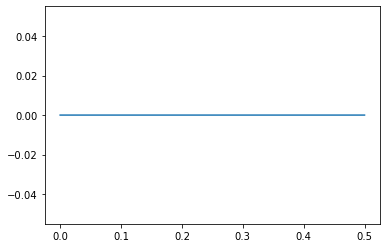

In [125]:
plt.plot(tlist,Ft)
ki

Consider that all the spins start in the same state, we only need to calculate the expectation values for one spin and the cavity

In [126]:
psi0_cav = basis(N, 0) # Cavity initialized in vacuum
psi0_spin = basis(2, 0) # Spins initialized in excited state

# Initialize the Matrices required for Debnath2019

# Time propagation

In [127]:
def da(a, dt, sm, Ft, N):
    a += (-1j*w_cav*a - gk*1j*np.sum(N*sm) - 1j*Ft)*dt
    return a
    
def da2(a2, dt, N, a_sm, a_sp, a, Ft):
    a2 += (-2j*w_cav*a2-2j*gk*np.sum(N*(a_sm + a_sp)) - 2j*Ft*a)*dt
    return a2

def dada(ada, dt, a_sp, Ft, a, N):
    ada += (-2*gk*np.sum(N*a_sp)-2j*Ft*np.imag(a)-kappa*ada)*dt
    return ada

def dsm(sm, dt, w_spin, a_sz):
    sm += (-1j*w_spin + 1j*a_sz*gk)*dt
    return sm

def dsz(sz, dt, a_sp):
    sz += (4*gk*np.imag(a_sp) - gamma*(1+sz))*dt
    return sz

def da_sz(a_sz, dt, sz, N, sm_sz_s, sz_sm_d, a2, a_sp, a, sp, ada, a_sm, sm, Ft):
    a_sz += (-1j*w_spin*a_sz - 1j*gk*(sz + (N-1)*sm_sz_s) - \
            2j*gk*((a2*sp + 2*a*a_sp - 2*a**2*sp) - (a*np.conj(a_sp) + np.conj(a)*a_sm + (1+ada)*sm-2*np.abs(a)**2*sm))\
            - gamma*(a + a_sz) - 1j*Ft*sz - \
            1j*gk*np.sum(sz_sm_d*N[..., None], axis=0))*dt # Assuming that N is a row vector of size k
    return a_sz

def da_sm(a_sm, dt, sm_sm_d, N, sm_sm_s, a2, a, sz, a_sz, sm, Ft):
    a_sm += (-1j*(w_spin+w_cav)*a_sm - 1j*gk*((N-1)*sm_sm_s - 2*a_sz*a - a2*sz\
            + 2*a**2*sz)-1j*Ft*sm -1j*gk*np.sum(sm_sm_d*N[..., None], axis=0))*dt
    return a_sm

def da_sp(a_sp, dt, sz, N, sm_sp_s, sp_sm_d, a, a_sz, ada, Ft, sp):
    ad = np.conjugate(a)
    a_sp += (1j*(np.conjugate(w_spin)-w_cav)*a_sp-.5j*gk*(1-sz)-1j*gk*(N-1)*sm_sp_s\
            -1j*np.sum(sp_sm_d*N[..., None], axis=0)-1j*gk*((1+ada)*sz + 2* np.real(a_sz*ad) -2*np.abs(a)**2*sz)\
            -1j*Ft*sp)*dt
    return a_sp

def dsm_sz_s(sm_sz_s, dt, a, sz, a_sz, sz_sz_s, a_sm, a_sp, sm_sp_s, sp, sm, sm_sm_s):
    ad = np.conjugate(a)
    sm_sz_s += (-1j*w_spin*sm_sz_s+1j*gk*(a*sz_sz_s+2*sz*a_sz-2*a*sz**2)-2j*gk\
    *(a_sm*sp+a_sp*sm+a*sm_sp_s-2*a*sm*sp-(ad*sm_sm_s+2*np.conjugate(a_sp)*sm\
    -2*ad*sm**2))-gamma*(sm+sz_sz_s))*dt
    return sm_sz_s

def dsm_sp_s(sm_sp_s, dt, a, sm_sz_s, a_sp, a_sz, sz, sm):
    sm_sp_s += (2*np.imag(w_spin)*sm_sp_s + \
               2*gk*np.imag(sz*np.conjugate(a_sp)+\
                           np.conjugate(a)*sm_sz_s+sm*np.conjugate(a_sz)-\
                          2*np.conjugate(a)*sm*sz))*dt
    return sm_sp_s

def dsm_sm_s(sm_sm_s, dt, a_sm, a_sz, sm_sz_s, sm, sz, a):
    sm_sm_s += (-2j*w_spin*sm_sm_s+2j*gk*(a*sm_sz_s+a_sm*sz+a_sz*sm-\
                2*a*sm*sz))*dt
    return sm_sm_s

def dsz_sz_s(sz_sz_s, dt, sm_sz_s, sz):
    sz_sz_s += (8*gk*np.imag(np.conjugate(sm_sz_s)) - \
               2*gamma*(sz + sz_sz_s))*dt
    return sz_sz_s

def dsm_sm_d(sm_sm_d, dt, a, sz, sm, a_sz, a_sm, sz_sm_d):
    N = np.size(w_spin)
    w_spin_r = np.tile(w_spin, N).reshape(N, N)
    w_spin_c = w_spin_r.T
    a_sz_c = np.vstack(a_sz)
    sm_c = np.vstack(sm)
    a_sm_c = np.vstack(a_sm)
    sz_c = np.vstack(sz)
    
    sm_sm_d += (-1j*(w_spin_r + w_spin_c)*sm_sm_d + \
               1j*gk*(a*sz_sm_d + sm_c*a_sz + sz*a_sm_c - 2*a*sz*sm_c)\
               +1j*gk*(a*sz_sm_d.T + sm*a_sz_c+sz_c*a_sm - 2*sm*sz_c))*dt
    
    np.fill_diagonal(sm_sm_d, 0)
    
    return sm_sm_d

def dsz_sz_d(sz_sz_d, dt, a_sp, a_sz, sz_sm_d, a, sp, sz):
    N = np.size(sz)
    a_sz_c = np.vstack(a_sz)
    a_sp_c = np.vstack(a_sp)
    sp_c = np.vstack(sp)
    sz_c = np.vstack(sz)
    sz_mat_c = np.tile(sz_c, N)
    sz_mat_r = np.tile(sz, N).reshape(N, N)
    
    sz_sz_d += (4*gk*np.imag(a*np.conjugate(sz_sm_d).T + \
                sp*a_sz_c + a_sp*sz_c - 2*a*sp*sz_c) + \
               4*gk*np.imag(a*np.conjugate(sz_sm_d) + \
                a_sz*sp_c + sz*a_sp_c - 2*a*sz*sp_c) -
               gamma*(sz_mat_c + sz_mat_r + 2*sz_sz_d))*dt
    np.fill_diagonal(sz_sz_d, 0)
    return sz_sz_d

def dsz_sm_d(sz_sm_d, dt, a_sz, sz_sz_d, sz, a, sp_sm_d, sp, sm, a_sp, a_sm, sm_sm_d):
    ad = np.conjugate(a)
    N = np.size(sm)
    w_spin_c = np.vstack(w_spin)
    sz_c = np.vstack(sz)
    sm_c = np.vstack(sm)
    a_sm_c = np.vstack(a_sm)
    a_sz_c = np.vstack(a_sz)
    ad_sm = np.conjugate(a_sp)
    ad_sm_c = np.vstack(ad_sm)
    sm_mat_c = np.tile(sm_c, N)
    
    sz_sm_d += (-1j*w_spin_c*sz_sm_d\
                + 1j*gk*(a*sz_sz_d + a_sz*sz_c + a_sz_c*sz\
               -2*a*sz*sz_c) - 2j*gk*((a*sp_sm_d + a_sp*sm_c + a_sm_c*sp - 2*a*sp*sm_c)\
               -(ad*sm_sm_d + ad_sm*sm_c + ad_sm_c*sm - 2*ad*sm*sm_c))\
               -gamma*(sm_mat_c + sz_sm_d))*dt
    np.fill_diagonal(sz_sm_d, 0)
    return sz_sm_d

def dsp_sm_d(sp_sm_d, dt, sz_sm_d, a_sp, a_sz, sp, sz, sm, a):
    ad = np.conjugate(a)
    w_spin_c = np.vstack(w_spin)
    sp_sz_d = np.conjugate(sz_sm_d).T
    ad_sz = np.conjugate(a_sz)
    ad_sm_c = np.conjugate(a_sp).T
    sz_c = np.vstack(sz)
    sm_c = np.vstack(sm)
    a_sz_c = np.vstack(a_sz)
    sp_sm_d += (-1j*(w_spin_c-np.conjugate(w_spin)*sp_sm_d+1j*gk*\
                (a*sp_sz_d)+a_sp*sz_c+a_sz_c*sz-2*a*sp*sz_c)-1j*gk*\
                (ad*sz_sm_d+ad_sz*sm_c+ad_sm_c*sz-2*ad*sz*sm_c))*dt
    np.fill_diagonal(sp_sm_d,0)
    return sp_sm_d

In [128]:
w_spin = delta_a - 1j*(gamma/2. + Gamma)
w_cav = delta_c - 1j*kappa/2.

a_0 = 0. # Cavity initialized in vacuum
a2_0 = 0.
ada_0 = 0.

sm_0 = np.zeros(k, dtype=np.cfloat) # Spins originally excited
sp_0 = np.zeros(k, dtype=np.cfloat)
sz_0 = np.ones(k, dtype=np.cfloat) 

a_sz_0 = np.zeros(k, dtype=np.cfloat) # Product of expectation value of a and sz
a_sm_0 = np.zeros(k, dtype=np.cfloat)
a_sp_0 = np.zeros(k, dtype=np.cfloat)

sm_sz_s_0 = np.zeros(k, dtype=np.cfloat)
sm_sp_s_0 = np.zeros(k, dtype=np.cfloat)
sm_sm_s_0 = np.zeros(k, dtype=np.cfloat)
sz_sz_s_0 = np.ones(k, dtype=np.cfloat)
sm_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)
sz_sz_d_0 = np.ones((k, k), dtype=np.cfloat)
np.fill_diagonal(sz_sz_d_0, 0)
sz_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)
sp_sm_d_0 = np.zeros((k, k), dtype=np.cfloat)

In [129]:
gnd = np.asarray([0,1])
gnd_c=gnd[..., None]
np.inner(ex,sigmaz()*ex)

(1+0j)

In [130]:
ex_c = sigmap()*gnd_c
ex = np.asarray([1,0])
ex*sigmaz()*ex_c

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [134]:
%%time

a_t = np.empty(intervals, dtype=np.cfloat)
ada_t = np.empty(intervals, dtype=np.cfloat)
sz_t = np.empty((intervals, np.size(sz_0)), dtype=np.cfloat)

for ii in range(np.size(tlist)):
    a_0 = da(a_0, dt, sm_0, Ft[ii], ki)
    a2_0 = da2(a2_0, dt, ki, a_sm_0, a_sp_0, a_0, Ft[ii])
    ada_0 = dada(ada_0, dt, a_sp_0, Ft[ii], a_0, ki)
    sm_0 = dsm(sm_0, dt, w_spin, a_sz_0)
    sz_0 = dsz(sz_0, dt, a_sp_0)
    a_sz_0 = da_sz(a_sz_0, dt, sz_0, ki, sm_sz_s_0, sz_sm_d_0, a2_0, a_sp_0, a_0, sp_0, ada_0, a_sm_0, sm_0, Ft[ii])
    a_sm_0 = da_sm(a_sm_0, dt, sm_sm_d_0, ki, sm_sm_s_0, a2_0, a_0, sz_0, a_sz_0, sm_0, Ft[ii])
    a_sp_0 = da_sp(a_sp_0, dt, sz_0, ki, sm_sp_s_0, sp_sm_d_0, a_0, a_sz_0, ada_0, Ft[ii], sp_0)
    sm_sz_s_0 = dsm_sz_s(sm_sz_s_0, dt, a_0, sz_0, a_sz_0, sz_sz_s_0, a_sm_0, a_sp_0, sm_sp_s_0, sp_0, sm_0, sm_sm_s_0)
    sm_sp_s_0 = dsm_sp_s(sm_sp_s_0, dt, a_0, sm_sz_s_0, a_sp_0, a_sz_0, sz_0, sm_0)
    sm_sm_s_0 = dsm_sm_s(sm_sm_s_0, dt, a_sm_0, a_sz_0, sm_sz_s_0, sm_0, sz_0, a_0)
    sz_sz_s_0 = dsz_sz_s(sz_sz_s_0, dt, sm_sz_s_0, sz_0)
    sm_sm_d_0 = dsm_sm_d(sm_sm_d_0, dt, a_0, sz_0, sm_0, a_sz_0, a_sm_0, sz_sm_d_0)
    sz_sz_d_0 = dsz_sz_d(sz_sz_d_0, dt, a_sp_0, a_sz_0, sz_sm_d_0, a_0, sp_0, sz_0)
    sz_sm_d_0 = dsz_sm_d(sz_sm_d_0, dt, a_sz_0, sz_sz_d_0, sz_0, a_0, sp_sm_d_0, sp_0, sm_0, a_sp_0, a_sm_0, sm_sm_d_0)
    sp_sm_d_0 = dsp_sm_d(sp_sm_d_0, dt, sz_sm_d_0, a_sp_0, a_sz_0, sp_0, sz_0, sm_0, a_0)
    a_t[ii] = a_0
    ada_t[ii] = ada_0
    sz_t[ii] = sz_0
    
    clear_output(wait=True)
    display('Iteration ' +str(ii))

'Iteration 9999'

CPU times: user 21.3 s, sys: 3.92 s, total: 25.2 s
Wall time: 26.1 s


In [132]:
Ft[ii]

0.0

/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/pethidine/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


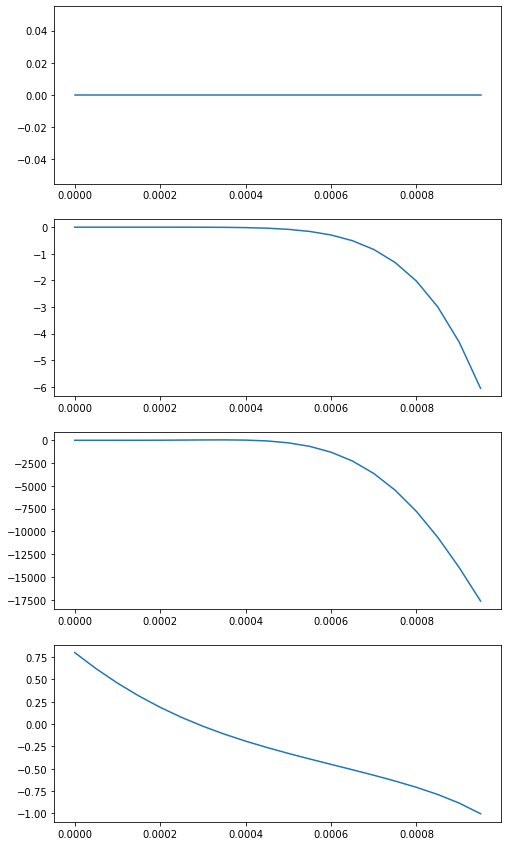

In [133]:
end=20

fig, ax = plt.subplots(4, 1, figsize=(8,15))
ax[0].plot(tlist[:end], Ft[:end])
ax[1].plot(tlist[:end], a_t[:end])
ax[2].plot(tlist[:end], ada_t[:end])
ax[3].plot(tlist[:end], np.mean(sz_t[:end], axis=1))

In [74]:
np.shape(tlist[:100])

(100,)

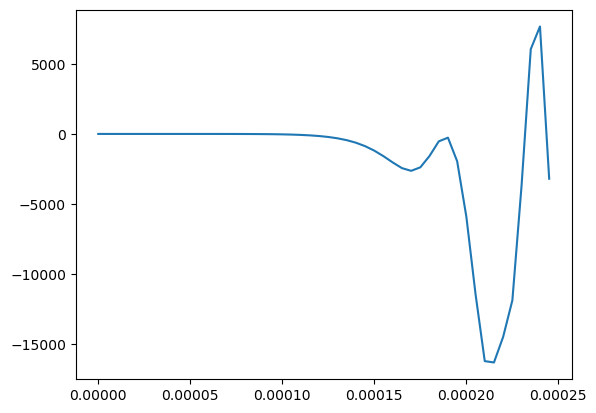

In [40]:
plt.plot(tlist[:50], a_t[:50])

In [129]:
np.vstack(basis(2,1))

array([[0.+0.j],
       [1.+0.j]])

In [130]:
sigmaz()*basis(2,1)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.]
 [-1.]]

In [133]:
bra("e")*sigmaz()*basis(2,1)

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-1.]]